**Student's name**

This aim of this course is to review the evolution of image processing tools from hand-crafted methods to deep learning algorithms. The semester is split into four labs :

* **Lab 1** : Introduction to Image Processing Using Hand-Crafted Features
* **Lab 2** : Object detection
* **Lab 3** : Object tracking
* **Lab 4** : Introduction to Deep Learning for image classification and generative model

Let's start with the second chapter of this course!

# Chapter 2 : Object Detection and Recognition
(*100 points*)

In [2]:
!pip install scikit-learn imageio

import cv2 as cv
import numpy as np
import os
import glob
import math
import tarfile
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

## 2.1 Template Matching
(*40 points*)

In this warm-up section, we will address the problem of detection and recognition using Template Matching. 

Template matching is a 'brute-force' algorithm for object recognition. The most basic method of template matching is to directly compare the grayscale images, without using edge detection. For example, if you were trying to detect, let's say a football, you will need to create a base template of the object. During the operation, the template matching algorithm would analyze the current image to find areas which are similar to the template. This basic approach is quite limited. For one thing, it is not robust to inconsistent changes in brightness within the image. If the template image has strong features, a feature-based approach may be considered; the approach may prove further useful if the match in the search image might be transformed in some fashion. For templates without strong features, or for when the bulk of the template image constitutes the matching image, a template-based approach may be effective. 

In the naive approach, the difference between the template and the matching area is computed pixel by pixel and used to calculate the overall error. It is possible to reduce the number of sampling points by reducing the resolution of the search and template images by the some factor and performing the operation on the resultant downsized images (multiresolution, or Pyramid (image processing)), providing a search window of data points within the search image so that the template does not have to search every viable data point or a combination of both.

![Template Matching Sample](../data/templateMatch.jpeg)

Template matching example. Left: Template image. Right: Input image with the resulting image highlighted.  

### 2.1.1 Objectives

In this section, we will explore the advantages and disadvantages of template matching method. However, in contrast with the previous Chapter, we will leave most of the implementation for the reader (i.e. you).

The following section will introduce to the most common metrics used for the matching distance and how to are used in OpenCV. Your task will be to: 
 * Implement each metric *by hand* 
 * Compare the accuracy against the OpenCV method 
 * Analyse and report your observations for each metric in 3 exercises and one mini-challenge.

As the final exercise, you will be given a set of more "challenging" data examples where using what you *learned before*, you will be asked to detect several objects in the scene. Your resulting algorithm __should have the given set of inputs and outputs__.

### 2.1.2 Distance, Minimums and Maximums

The two (and pretty much only) important parts of the Naive Template Matching algorithm is the *distance transform*, i.e. the metric to know if we found a match or not, and the global minima detection. 

For an  Input image $I$ if size $W\times H$, a template Image $T$ of size $w\times h$; ($w<W, h<H$), the distance methods implemented in OpenCv are the following: 

* Mean Squared Difference Method=CV_TM_SQDIFF

\begin{equation*}
R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2 
\end{equation*}

* Normalized Mean Squared Difference Method=CV_TM_SQDIFF_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Cross Correlation Method=CV_TM_CCORR
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T(x',y') \cdot I(x+x',y+y'))
\end{equation*}

* Normalized Cross Correlation method=CV_TM_CCORR_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Correlation Coefficient Method=CV_TM_CCOEFF
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T'(x',y') \cdot I'(x+x',y+y'))
\end{equation*}

where

\begin{equation*}
\begin{array}{l} T'(x',y')=T(x',y') - 1/(w \cdot h) \cdot \sum _{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w \cdot h) \cdot \sum _{x'',y''} I(x+x'',y+y'') 
\end{array}
\end{equation*}

* Normalized Correlation Coefficient=CV_TM_CCOEFF_NORMED
\begin{equation*}
        R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }
\end{equation*}


Please notice that the dimensions of the output image, $R$, will depend on how you handle the edges. The easiest way is to ser the return an output image of size $(W-w+1, H-h+1)$.

After the function finishes the comparison, the resulting image will contain an image map with the obtained values. In OpenCV, the best matches can be found as global minimums or maximums (depending which matric you used) using the `minMaxLoc()` function. 

#### 2.1.2.1 Exercise

From the functions listed above, indicate if the best matching position is located either in the local minimums or in the maximums. 

**Write your answer here**

Mean Squared Difference: Minimum

Normalized Mean Squared Difference Method: Minimum

Cross Correlation: Maximum

Normalized Cross Correlation: Maximum

Correlation Coefficient: Maximum

Normalized Correlation: Maximum

#### 2.1.2.2 Exercise

Implement at least 3 of the functions listed above, and use them as arguments in the base method provided

In [20]:
## YOUR CODE HERE, your distance functions

def tm_sqdiff(image_patch, template):
    return np.sum((image_patch-template)**2)

def tm_sqdiff_normed(image_patch, template):
    return np.sum((image_patch-template)**2) / np.sqrt(np.sum(image_patch**2) * np.sum(template**2))


In [21]:
img_gray = cv.imread('../data/space-invaders_1.jpg', 0)
template = cv.imread('../data/template_0.png', 0)

def template_matching_process(image, template, dist_fn):
    """
    Given an input image, iterates over the image and computes the distance w/r
    the template, using a given distance function. 

    :input_image:       Input image. :) 
    :template:          The Template Image.
    :distance_function  Function used to compute the distance. The function should receive a image patch 
                        and a template as inputs.
    :return:            The distance map.
    """
    W = image.shape[1];
    H = image.shape[0];
    
    w = template.shape[1];
    h = template.shape[0];

    # Output image/map
    dist_map = np.zeros((H-h+1,W-w+1), dtype=np.float32)

    # we could avoid the fors by using lambda funnctions.
    for y in range(dist_map.shape[0]):
        for x in range(dist_map.shape[1]):
            # We take just the sub-patch where to compute the distance
            holder_patch = image[y:y+h, x:x+w];
            # for each point we compute the distance w/r the template
            dist_map[y, x]= dist_fn(holder_patch, template); 
    return dist_map

# Use it like this
dist_map = template_matching_process(img_gray, template, tm_sqdiff_normed)

plt.figure(figsize=(12.8, 8.2))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title('Image')

plt.subplot(132)
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.title('Template')

plt.subplot(133)
plt.imshow(dist_map, cmap='gray')
plt.axis('off')
plt.title('Distance Map')

plt.show()

C:\Users\sjean\AppData\Local\Temp/ipykernel_11904/3791937614.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum((image_patch-template)**2) / np.sqrt(np.sum(image_patch**2) * np.sum(template**2))


KeyboardInterrupt: 

#### 2.1.2.3 Exercise

Check your outputs by using the build-in functions in OpenCV to compute the maps for each of the methods implemented. Show in each cell: your map and the OpenCV map.

Text(0.5, 1.0, 'OpenCv Distance Map')

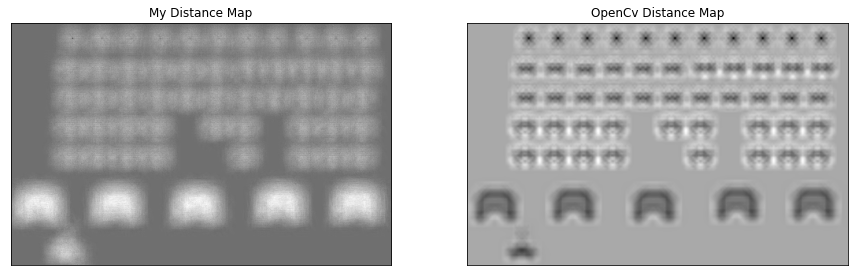

In [9]:
# Example
res = cv.matchTemplate(img_gray, template, cv.TM_SQDIFF)

# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(15, 7),squeeze=False)
display_image(dist_map, axes=ax[0][0])
ax[0][0].set_title("My Distance Map")
display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv Distance Map")

## YOUR CODE HERE
# ....




As you may have noticed, the self-implemented method is quite slow even for small images, since it increases quadratically for the input image and also the template image. OpenCV implements the same function optimally (low-level implementation).

### 2.1.3 Finding Local Minimums / Maximums

As explained before, in order to find the location of our possible object we need to find the minimum or maximum point in our resulting distance map. Using OpenCV, the function `minMaxLoc()` can be used to find the local minimum and maximum of the single-channel array (1D or 2D) [[doc](https://docs.opencv.org/4.0.0/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707)]. 

However, if we happen to have several objects in the image that we would like to match `cv.minMaxLoc()` won't give you all the locations. 

#### 2.1.3.1 Exercise

Write your own function, `multiMinMax(src, flag, params)`, which should take an input 2D image `src` and return an `output_array` with the local minimums or maximums depending on the provided `flag` (`flag = "min"` or `flag = "max"`), and a given `params`. The `params` can be, for example, a _threshold_ for the local minima/maxima, the maximum number of maximums/minimums to return, a difference between the global maxima/minima to be included, etc.

In [ ]:
def multiMinMax(src, flag, params):
    
    ## YOUR CODE HERE
    # ...
                
    return (np.asarray([0]), np.asarray([0]))

In [ ]:
def drawROIS(src, template, locations, color = (0, 0, 255)):
    w, h = template.shape[::-1]
    # Make copy of image to draw on it without changing the original image
    canvas = src.copy();
    
    # Draw all rectangles
    for pt in zip(*locations[::-1]):
        cv.rectangle(canvas, pt, (pt[0] + w, pt[1] + h), color, 2)
    
    return canvas

# How should be called:
img_rgb  = cv.imread('../data/space-invaders_1.jpg')
img_gray = cv.imread('../data/space-invaders_1.jpg',0)
template = cv.imread('../data/template_0.png',0)

# For a given distance Map
distance_map_norm_corr = cv.matchTemplate(img_gray, template, cv.TM_CCORR_NORMED)
# Use your function here!
locations = multiMinMax(distance_map_norm_corr, 'max', None)
# Draw the ROIs 
img_rgb_holder = drawROIS(img_rgb, template, locations)
# example:
display_image(img_rgb_holder)
# How many ROIS did you returned? 
print(np.array(locations).shape)

#### 2.1.3.2 Exercise

Now that you are all set up, use the functions above and *try* to detect ALL the matching objects in the input image (Using template Matching).

Rules:

* You can use any metric you want, self-implemented or from OpenCV. 
* You can tweak your multiMinMax to get better results.
* For 1) and 2) and 3) you have to do it in grayscale.
* 4) can use multi-channel heuristics.


#### 1) Perfect match <3

Using the base input provided, plot the input image _showing_ the locations of the matching objects for the 2 provided templates.

Follow the code below and provide some insights like:

* Why did you choose that given metric?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 



In [ ]:
# input images to use
p1_src_rgb    = cv.imread('../data/space-invaders_1.jpg')
p1_src_gray   = cv.imread('../data/space-invaders_1.jpg',0)

# Show the matching of these 2 templates:
p1_template_1 = cv.imread('../data/template_1.png',0)
p1_template_2 = cv.imread('../data/template_2.png',0)

# Image
display_image(p1_src_gray)
fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)

# Templates
display_image(p1_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p1_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

In [ ]:
## YOUR CODE HERE
# .....




#### 2) Not so perfect Match </3

Plot the input image _showing_ the locations of the matching objects and any false positive. All the _invaders_ in the same row counts as the "same" class. 

Follow the code bellow and provide some insights like:

* How did you select the number of maximums/minimus?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 
* Could you use any of the features from the last chapter to improve the matching?

In [ ]:
# input
p2_src_rgb    = cv.imread('../data/space-invaders_2.jpg')
p2_src_gray   = cv.imread('../data/space-invaders_2.jpg',0)

# 2 tempaltes (check that tempalte one don't match all the invaders in the same row) 
p2_template_1 = cv.imread('../data/template_3.png',0)
p2_template_2 = cv.imread('../data/template_1.png',0)

# Image
display_image(p2_src_gray)

# Templates
fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)
display_image(p2_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p2_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

In [ ]:
## YOUR CODE HERE
# .....



#### 3) Hidden objects game


Finding hidden objects in cluttered illustration is a popular casual game that develops your observation skills. In this exercise, you will use your template matching skills to establish an efficient object detector for this game.


We will play with an example from the **Big Home Hidden Objects** game, where images to find are shown at the bottom. We provide you the method `extract_big_home_templates` to extract the grayscaled template of each object from the image.

Your task is to use these templates and what you have learned to find the hidden objects in the given illustration.

Plot the input image _showing_ the location of each object and _report_ the number of misses (we expect at most 5). Note each object is present once in the scene. So you can write a variant of `multiMinMax` (e.g `minMax`) which returns the global minimum or maximum of a 2D `src` image according to the provided `flag` (`flag = "min"` or `flag = "max"`). You can reuse the function `cv.minMaxLoc()`.


In this exercise, you may choose to use any transformation in the input image (like the scale to save time) or tweak the distance metric. You can't modify the templates (only scale it).

Follow the code below and provide some insights like:

* What metric seemed to work better this time? 
* Was it different from the previous exercise?
* How many objects did you find? Why are these in particular?

Save the output in a separate image for easier visualization.

In [ ]:
# DO NOT MODIFY THIS FUNCTION
def extract_big_home_templates(image):
    
    # We extract list of objects in a heuristic manner
    list_image = image[370:418, 77:712].copy()
    
    # There are 10 objects per image
    n_objects = 10
    stride = list_image.shape[1]/10
    
    # Extract each template image
    objects = []
    for i in range(n_objects):
        object_rgb = list_image[:,int(stride*i):int(stride*(i+1))][15:-15,15:-15]
        center_coordinates = (int(object_rgb.shape[1]/2), int(object_rgb.shape[0]/2))
        object_rgb = cv2.ellipse(object_rgb, center_coordinates, (40, 32), 0, 0, 360, (35, 35,35), 20)
        object_gray = cv2.cvtColor(object_rgb, cv2.COLOR_BGR2GRAY)
        objects.append(object_gray)
        
    return objects

In [ ]:
# inputs
hidden_rgb  = cv.imread('../data/hidden.jpeg')

# get list of templates
templates = extract_big_home_templates(hidden_rgb)
hidden_rgb = hidden_rgb[80:360]
hidden_gray = cv2.cvtColor(hidden_rgb, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(10, 10),squeeze=False)

display_image(hidden_rgb, axes=ax[0][0])
ax[0][0].set_title("Input")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

plt.show()

fig, ax = plt.subplots(1,10, figsize=(20, 20),squeeze=False)

for i, template in enumerate(templates):
    display_image(template, axes=ax[0][i])
    ax[0][i].set_title("Templates {:d}".format(i+1))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])

In [ ]:
def minMax(src, flag):
    ### Your code below
    #
    location = (0,0)
    
    return location

In [ ]:
## YOUR CODE HERE
# ...


#### 4) Find all hidden objects

As you can see, using template matching can be tricky, even when you have _good_ templates. As for the last exercise, you will try to design good __templates__  (it can be done in Paint if you want =P) in order to find all hidden objects in the image. In this exercise, you can (if you wish to) use the information of the 3 RGB channels (to generate a _better_ 1 channel image, for example) and transform the input image (for example, to homogenize the scale!). You can reuse any features from the last chapter to improve the matching.
Plot your selected templates and the input image _showing_ the location of each object (if you can) and any miss, if any.

Follow the code below and provide some insights like:

* Was it different from the previous exercise?
* What did you improve?

In [ ]:
# inputs
hidden_rgb  = cv.imread('../data/hidden.jpeg')

# get list of templates
hidden_rgb = hidden_rgb[80:360]
hidden_gray = cv2.cvtColor(hidden_rgb, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(10, 10),squeeze=False)

display_image(hidden_rgb, axes=ax[0][0])
ax[0][0].set_title("Input")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

plt.show()

fig, ax = plt.subplots(1,10, figsize=(20, 20),squeeze=False)

# YOUR CODE HERE TO LOAD YOUR TEMPLATES
templates = []

for i, template in enumerate(templates):
    display_image(template, axes=ax[0][i])
    ax[0][i].set_title("Templates {:d}".format(i+1))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])

In [ ]:
## YOUR CODE HERE
# ...



## 2.2 Person Detection
(*30 points*)

In this section, we will return to the HOG features from the last Chapter. As we said before, HOG was proposed as a useful feature for human detection. If you reach this point, you may have noticed that Template matching may not be the best option for this. Imagine how difficult it would be to create a template for any human-shaped structure that you would like to detect as a human in a scene. Instead of that, you will train a Linear Classifier from scratch.
Section objectives:
In this section, since you know the basics of HOG, you will use OpenCV's implementation to extract the HOG's features of the curated INRIA's Persons dataset to train an SVM Linear classifier (https://en.wikipedia.org/wiki/Support_vector_machine). For this, instead of using OpenCV's (already trained) classifier, we will use the Scikit-learn Machine Learning library (http://scikit-learn.org). Which is one of the most used machine learning libraries around this days.

### 2.2.1 Dataset 

 This dataset was collected as part of the research work on detection of upright people in images and video. The research is described in detail in the CVPR 2005 paper _Histograms of Oriented Gradients for Human Detection_. The full dataset is about ~1 GB and contains several thousands of pedestrian images. 
 
For your convenience, the dataset is already separated into two sets: 
* "**_Positives_**" which are all the images containing at least one person. 
* "**_Negatives_**" any kind of non-human shaped objects images.

In addition, the data is already separated in a **training** and **testing** set (seriously, it cannot be more conveniently done).

You can download the dataset using this [link](ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar) and put the `.tar` file into the `data` folder. To uncompress the data, you can either use the function below or directly do it in your file explorer, it is up to you.

In [ ]:
def maybe_extract(filename, force=False):
    """
    Uncompress a given *.tar file
    :param filename: File to be uncompressed
    """
    # remove .tar.gz
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        tar.extractall(os.path.dirname(filename))
        tar.close()
    print("All setup.")

In [ ]:
# Optional
maybe_extract(filename='../data/INRIAPerson.tar')

### 2.2.2 Features Extraction

Once you have the data, you will now process each image on both: _positive_ and _negative_ folders using the OpenCV HOG Descriptor implementation [[doc](https://docs.opencv.org/4.0.0/d5/d33/structcv_1_1HOGDescriptor.html)]: 

Your job: Using the skeleton provided below, for each image in the "pos" and "neg" folder of the *training* set:

* Compute the hog feature vector using the parameters provided below. 
    * The length of each individual feature vector should be of 16800. Derive bellow why is of this size. (Hint: Imagine that you have an image of size (32,32) which would be the size of this case?).
   
* Append the feature vector to the _training_feature_ list.
    * The total size of this list should be of (16800, number of images in your training set). 

* For each image add to the _label_ vector a 1 if it's positive or 0 if it's negative. The final length of the _labels_ should be the number of images in your full training set.

**WARNING**: The dataset may contain corrupted images. Be sure, inside your code, to check if the image was loaded properly. Otherwise, you will get either trash features or execution errors.

Previously, some student had issues loading the images. That's why we've provided four text files (i.e. `inria_{train, test}_{pos, neg}.txt`) to solve the issue. Each line in the file indicates the path to an image. Moreover sometimes OpenCV can not load the image properly, that's why we're gonna use another package to load them. The command below shows how to achieve the same as `cv2.imread(...)` function.

```python
np.flip(np.asarray(imageio.imread('<image_path>', dtype=np.uint8))[..., :3], -1)
```

The `imread(...)` function load the image, it is then converted to numpy array with `np.asarray()`. Only the first 3 channels are selected with `[..., :3]` and finally it is converted from `RGB` to `BGR` with the `np.flip(..., -1)` function.

In [ ]:
# Data location
#Positive folder:
pos_im_path = "../data/inria_train_pos.txt"
#Negative folder:
neg_im_path = "../data/inria_train_neg.txt"


# Image descriptor parameters
# ---------------------------
# Window size: this specifies the size of the input image (remember to scale the input to this size!)
win_size     = (64,128)
# Size on pixels of each block (remember that a block contains a set of CELLS)
block_size   = (16,16)
# The separation between each block. If this value is less than the block size, 
# there will be overlapping blocks. 
block_stride = (8,8)
# The size of each CELL. Each cell computes one histogram. The cells should FIT inside a block.
cell_size = (4,4)
# Number of bins for each histogram.
nbins = 10

# Samples
# ---------------------------
# list to save ALL the features.
training_features = []
# Auxiliary array to label each features if it comes from a "positive"(1) or "negative" (0) image.
labels = []

print ("Calculating the descriptors for the positive samples...")


## YOUR CODE HERE
# .....
    
    
print ("Calculating the descriptors for the negative samples...")
## YOUR CODE HERE
# .....



### 2.2.3 Classifier

Now that you have this features computed and saved in a feature matrix, you are pretty much set to train a classifier. 

scikit-learn provides all the implementation needed to train a linear classifier with no more than 2 lines of code! (Which is awesome and sad at the same time). 

For this exercise, you will use a Linear Support Vector Classifier [[doc](
http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)].

Please take the time to read the implementation details, but more importantly, the examples and theory provided in the documentation. If you are not interested in knowing stuff, you can jump right away to use the implemented functions in the block below.

In [ ]:
## YOUR CODE HERE
# ...


### 2.2.4 Evaluation

After training the classifier -which a fancy way to say that you fitted a 1-D vector of coefficients!- you can use this Support Vector Machine to *classify* if, given an input * HOG feature vector* (with strictly the same dimensions as your training data), it came from an image with a human-shaped form in it (prediction = 1), or not (prediction = 1).

*Your job*:

For each image in the test folders: 
* Compute the HOG feature vector.
* Predict/classify the vector as positive (1) or negative (0); *Hint: LinearSVC.predict(...)*
* Compute the estimation error for the negative and positive images _separetely_.
* Compute and report the F1-score [[doc](https://en.wikipedia.org/wiki/F1_score)]

In [ ]:
## YOUR CODE HERE
# ....

test_neg_path = "../data/inria_test_neg.txt"
test_pos_path = "../data/inria_test_pos.txt"



The basic classifier above can (should) achieve a success rate of 89% for the positive and less than 2% error for the negative images respectively. 

Can you tweak the HOG parameters to improve a little bit?

In [ ]:
## YOUR CODE HERE
# ....




Finally, from the description above, what we created is no more than a *classifier* for only 2 classes (binary classifier): human(human-shaped) or not. In order to create a functional Person detector for arbitrary images or video sequences, some engineering techniques (heuristics) need to be implemented. 

Pretty much as in template matching, in order to find a person in an arbitrary image you will need to: 

* Slide your classifier over the full area of the image.
* Detect possible matchings. 
* Report them as positive or negatives
* And optionally, repeat the procedure above in different scales, to assure multiscale detection!.

The procedure is nicely depicted in the image below for face detection.

<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/03/sliding-window-animated-adrian.gif"> 
</img>
Image taken from: https://www.pyimagesearch.com

For now, we will leave those implementation details for later.

## 2.3 Face Recognition
(*30 points*)

In this section we will see how it is possible to recognize objects. The study case will target face regognition. Two approaches will be explored, `Eigen Faces` and `Fisher Faces` respectively. These methods are both based dimensional reduction technics listed below:

- Principal Component Analysis ([*PCA*](http://www.utdallas.edu/~herve/abdi-awPCA2010.pdf))
- Linear Discriminant Analysis (*LDA*)

In general, in order to train a recognizer, several steps are needed and can be grouped as follow:

- Data preparation
- Recognizer training
- System validation

It is important for the validation step to ensure that the system tested with **unseen** data. By unseen data we mean data that have not been used during the training phase, this will ensure a fair performance assessment without biais. However this does not garantie that the system will *generalize* well to other dataset.

### 2.3. 1 Data Preparation

Data preparation covers various aspect of pre-processing step for training a system. At first, the images need to be splitted into two disctinct subsets thant will be used for `training` and `testing`. In our experiment the dataset used is the *Yale dataset version B*, it includes a total of 38 different identity (*i.e. subject*) each having 20 images undergoing different illumination condition for a total of 760 samples. The splitt will be done by chosing randomly samples from each subjects and placed into the corresponding subset, special care need to be taken in order to avoid having the same example multiple time.

The first task is to gather the labels and the images that will be used to train the system. One solution is to store these information into a dictionary where the identity is the key and the pathes to the images for this subject are the values. 

**Your Answer**

In [ ]:
def load_dataset(path):
    """
    Scan for images in a given `path` and extract the label as well

    :param path:    Path where YaleB dataset is stored
    :return:        Dictionary storing the ID and a list of images for this ID
    """
    data = {}
    # Scan folder
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    # Query images for each subject and extract the subject's ID
    
    # YOUR CODE HERE
    # ....
    
        
        
    return data

In [ ]:
# Load data
data = load_dataset(os.path.join('..', 'data', 'yaleB'))
assert(len(data) == 38)

When all the images and labels have been gathered, the next step is to split into two subsets, the train set and test set. The training set will be composed of $75\%$ of the images of each subject and the remaining $25\%$ will be used as test set.

Once again the two subsets information will be stored into two separates disctionary similar to what has been done earlier.

**Your answer**


In [ ]:
def split_dataset(data, ratio):
    """
    Splipt randomly a dataset into two subset. The ratio provide the distribution for each subset

    :param data:    Overall dataset
    :param ratio:   Split ratio
    :return:        Two dictionaries, train/test
    """
    train = {}
    test = {}
    
    # YOUR CODE HERE
    # ....
    
    
    
        
    # return subsets    
    return train, test

In [ ]:
train, test = split_dataset(data, 0.75)
assert(len(train) == 38)
assert(len(test) == 38)

Now with these two subsets we can load the images and extract features from them. In this case the pixel intensity will be used as feature, therefore for an image $I \in \mathbb{R}^{ w \times h}$ the feature vector will have a size of $wh$. This value can be quite large very easily, therefore all images will be downsampled by a factor of $2$.

All the training samples will be concatenated into a single matrix where each row is an image (*i.e. flattened*) with dimensions $N \times K$ where $N$ is the number of samples and $K$ is the dimension of a single image, $K = \frac{wh}{4}$. The corresponding labels will also be concatenated into a single vector of dimension $N \times 1$.

**Your answer**

In [ ]:
def load_images(subset):
    """
    Load images into one single matrix where each row is one single image (flattened). The final dimensions is [N x K]
    where N is the numper of samples available and K is the number of pixel in one image. The original image is first
    downspample by a factor of 2

    Labels are also exported into a single vector of dimensions [N x 1]

    :param subset: Dictionary storing labels/images
    :return:       Data matrix and label vector
    """
    
    # data = ...
    # label = ...
    
    # YOUR CODE HERE
    # ....
    
    
    
    
            
            
            
    # Done
    return data, label

In [ ]:
# Load training images into memery
train_img, train_label = load_images(train)
# Sanity check
assert(train_img.shape[0] == train_label.size)
# Output number of samples
print("There is a total of {} samples for the training set".format(train_label.size))


### 2.3.2 Eigenfaces

To perform recognition, all pixel's intensities are used as feature vector. The dimension of theses descriptors will be large, therefore a *clever* representation of the data, called subspace, is needed. 

This subspace is computed using *Principal Component Analysis* method in order to extract meaningfull information and reduce the dimension of the problem. The *PCA* approach is completely unsupervised and extract the directions, or *basis*, where the variation in the data are the largest inside the feature space. 

Since we are interested in the variation in the data, the first step is to remove the commmon information present in all samples by subtracting the **average face**. The average is computed using all training samples $I_i$ as follow:

$$
\bar{\boldsymbol{I}} = \frac{1}{N_t} \sum_{i=0}^{N_t} \boldsymbol{I}_i
$$

where $N_t$ is the total number of training samples and $I_i$ is a specific training sample. Then each samples $I_i$ are normalized as follow:

$$
\boldsymbol{\phi_i} = \boldsymbol{I}_i - \bar{\boldsymbol{I}}
$$

With all samples normalized, we need to find a set of orthognonal basis which best explain the distribution of our data. To do so we compute the eigendecomposition of the covariance matrix of the normalized samples.

$$
\boldsymbol{C} = \frac{1}{N_t - 1} \sum_{i}^{N_t} \boldsymbol{\phi}_i\boldsymbol{\phi}_i^{\top} = \frac{1}{N_t - 1} \boldsymbol{\Phi\Phi}^{\top}, \quad \text{where } \Phi = \left[\boldsymbol{\phi}_0, \dots, \boldsymbol{\phi}_{N} \right]
$$

Find the eigenvectors $u_k$ and the eigenvalues $\lambda_k$. 

So far the dimensions of the problem have not been reduced. Moreover the size of the covariance matrix will be $K \times K$ with $K = \frac{wh}{4}$. Therefore we will find $K$ eigenvectors representing the variation in our data. To reduce the dimension we will select only the eigenvectors that contribute the most to the variation and dropping the one with little influence. Doing so will reduce the dimension of the subspace to $K \times K_m$.

The question is how to properly determine this $K_m$ value. It can be done by using the eigenvalues computed earlier. These values are representing the energy each vector contribute for. Therefore it is possible to dertmine the number of basis to select in order to retain a certain amount of energy.

$$
\frac{\sum_{k=0}^{K_m}\lambda_k}{\sum_{i=0}^{K}\lambda_i} < \Theta
$$

Where $\Theta$ represents the amount of energy to retain, which usually is around $95\%$ but can vary depending on the application. 
Finally the subspace is defined as:

$$
\boldsymbol{U} = \left[\boldsymbol{u}_0, \dots, \boldsymbol{u}_{K_m}\right], \quad \boldsymbol{U} \in \mathbb{R}^{K \times K_m}
$$

In practice, the PCA decomposition is computed using `sklearn.decomposition.PCA`, more information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

For now, compute the face subspace on the training data by retaining $95\%$ of the variance present in the training data.
Once the subspace is computed, display the first $8$ modes or *eigenfaces* and comment on what you see, what do you thing are the limitations of such approach ?

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....



With our freshly subspace computed we can try to visualize if it separates properly the different subjects. Having proper plot of an $N$ dimensional space is not feasable, however we can use only a few components (*i.e. 2 or 3*) of our projected samples to visualize them. 


What we want is a subspace that is able to separates and clusters properly each subjects in order to avoid miss recognition. The code snippet below shows the $3^{rd}$ and $4^{th}$ components on a $2D$ plane.

What do you think about it, do we have clean inter-subject separation ?

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....
# Poject data onto subspace
proj_train = ...


# Visualize 
# Colors for distinct individuals
colors = LabelEncoder().fit_transform(train_label.ravel())

plt.figure(figsize=(12, 7))
plt.scatter(proj_train[:, 2], proj_train[:, 3], c=colors)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Trainset clusters')

With our learned subspace we need to defined the corresponding representation for the training samples. This can be done by projecting them into the eigen subspace (*i.e. eigenface*) as follow:

$$
\boldsymbol{\omega}_i = \boldsymbol{U}^\top \boldsymbol{\phi}_i
$$

In the training set, there are multiple samples avaible for each subject. Their projection won't be exactly the same, therefore we need to have a more generic representation of each person. To do so, we average all representation of the specific person to have his general representation.

$$
\boldsymbol{\Omega}_k = \frac{1}{N_k} \sum_{p} \boldsymbol{\omega}_p
$$

where $N_k$ is the number of samples for subject $k$, $\boldsymbol{\omega}_p$ represents the projected samples of subject $k$ respectively. In our case, $k$ goes from $0$ to $37$.

Now implement the function below that computes each subject's centroid, and returned their corresponding labels as well.

**Your answer**




In [ ]:
def compute_centroids(data, trsfrm, label):
    """
    Given a list of training samples, compute the centroids of each uniques labels

    :param data:    Matrix with all feature vectors stored as row
    :param trsfrm:  Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param label:   List of corresponding labels
    :return:        Centroids, unique labels
    """

    # extract unique label
    unique_lbl = np.unique(label)

    # YOUR CODE HERE
    # ....
    
    
        
        
    # Done
    return centroids, unique_lbl

In [ ]:
# Define centroids
train_centroids, train_centroid_label = compute_centroids(train_img, pca, train_label)
assert(train_centroids.shape[0] == 38)
assert(train_centroid_label.shape[0] == 38)

So far we've learned a face representation and computed the descriptor for the training samples. Now we can us them to recognize face. To do so the first step is to bring the *new* sample into our face *subspace* by projection, similarly  to what has been done before:

$$
\boldsymbol{\omega}_n = \boldsymbol{U}^{\top}(\boldsymbol{I}_n - \bar{\boldsymbol{I}})
$$

where $U$ is the face subspace, $\bar{\boldsymbol{I}}$ is the average face learned on the training data and $\boldsymbol{I}_n$ is the new sample to recognize.

Once the sample is in the same subspace as the training samples, we can measure its **similarity** (*distance*) with the centroids $\boldsymbol{\Omega}_k$ computed before. The predicted label will be the one corresponding the the closest centroid. 

$$ 
min \left|\left| \boldsymbol{\omega}_n - \boldsymbol{\Omega}_k \right|\right| \quad \forall k \in \{Train\}
$$

Using the prototype below implement a function that predict each labels of new samples.

**Your answer**


In [ ]:
def recognize(trsfrm, centroids, centroids_label, samples):
    """
    Perform object recognition on a given list of ``amples

    :param trsfrm:          Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param centroids:       List of centroids learned in training phase
    :param centroids_label: Label corresponding to the centroids
    :param samples:         List of samples to recognize
    :return:                Predicted labels
    """

    # Define output container
    pred = np.zeros((samples.shape[0], 1), dtype=np.float32)

    # YOUR CODE HERE
    # ....
    
    
    
        
    
    # Done
    return pred

One way to valid the implementation is to try the whole system on the training set. The expected recognition accuracy should by close to 100% depending on the task difficulty.

In [ ]:
# Recognize training set
pca_train_pred = recognize(pca, train_centroids, train_centroid_label, train_img)

# Compute performance
n_err = np.count_nonzero(np.where(pca_train_pred != train_label))
train_acc = 1.0 - n_err / train_label.size
print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))


Estimate the recognition accuracy on the testing set and comments on what you see

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....




Measuring accuracy of the system is a good indicator of the overall performance but does not indicate where the system is performing poorly. This can be quantified using **Confusion Matrix**. It describes the performance of classification model and shows how the system is confused for each samples in the training set.

Such representation can be computed using `sklearn.metrics.confusion_matrix`, details are provided [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

**Your anser**

In [ ]:
# YOUR CODE HERE
# ....




### 2.3.3 Fisherface

The subspace computed before with *PCA* was looking at directions where the variation in the data is maximum without paying attention to the class each data point belongs to. Therefore this approach is unsupervised. The major drawback is that the class separability is not garantee to be optimum. 

The approach of *Linear Discriminant Analysis* is to find a subspace where the variation is large (*i.e. similar to PCA*) but also to maximize the inter-class separability by taking into account each sample's label. The figure below shows an example:

<img src="../data/lda_example.png" alt="Drawing" style="width: 400px;"/>

Such subspace can be computed as follow:

- Compute the scatter matrices (*intra-classes* / *inter-classes*)
- Compute the eigenvectors / eigenvalues
- Select the $K_m$ largest eigenvalues and their corresponding eigenvectors

Given a set of samples $\boldsymbol{I}_0, \dots, \boldsymbol{I}_N$ and their corresponding labels $y_0, \dots, y_N$, the intra-class scatter matrix is computed as follow:

$$
\boldsymbol{S}_w = \sum_{i=1}^N \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right) \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right)^{\top}
$$

where $\boldsymbol{\mu}_{k}$ is the sample mean of the $k^{th}$ class.
Then the inter-class scatter matrix is defined as:

$$
\boldsymbol{S}_b = \sum_{k=1}^{m} n_k (\boldsymbol{\mu}_k - \boldsymbol{\mu})(\boldsymbol{\mu}_k - \boldsymbol{\mu})^{\top}
$$

where $m$ is the number of classes, $\boldsymbol{\mu}$ is the overall sample average and $n_k$ is the number of samples in the $k^{th}$ class.

Finally the subspace $\boldsymbol{W}$ can be computed by solving the following generalizeed eigenvalue problem:

$$
\boldsymbol{S}_b \boldsymbol{W} = \lambda \boldsymbol{S}_w \boldsymbol{w}
$$

Finally at most $m-1$ generalized eigenvectors are useful to discriminate between $m$ classes.

In practice, such decomposition can be computed using `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`, more information available [here](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

Now compute the *LDA* subspace similar to what you have done before and display the first 8 basis (*i.e. Fisherface*).

**Your answer**


In [ ]:
# YOUR CODE HERE
# ....




Similar to what we have done before visualize the subspace created by the *LDA* decomposition. 

What do you see, is it better than before ?

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....





Based on what has been done before, compute the recognition accuracy on the *training*/*testing* set for the *LDA* recognizer.

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....




Compute the *Confusion Matrix* and comment on the result you have

**Your answer**

In [ ]:
# YOUR CODE HERE
# ....



You have implemented / tested two approaches for face recognition which one works the best and why ? What's are the pro/cons of each method ?

**Your answer**